In [17]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from xgboost import XGBRegressor


In [38]:
# Load the dataset (renaming the file for uniqueness)
df = pd.read_csv("C:/Users/indig/Downloads/Business_Stats.csv")


In [15]:
print(df.columns)


Index(['segment', 'country', 'product', 'discount_band', 'units_sold',
       'manufacturing_price', 'sale_price', 'gross_sales', 'discounts',
       'sales', 'cogs', 'profit', 'date', 'month_number', 'month_name',
       'year'],
      dtype='object')


In [16]:
# Clean up the column names by removing leading and trailing underscores
df.columns = df.columns.str.strip('_')

# Now, the column names will be cleaner, like 'units_sold' instead of '_units_sold_'
print(df.columns)  # Check the cleaned column names


Index(['segment', 'country', 'product', 'discount_band', 'units_sold',
       'manufacturing_price', 'sale_price', 'gross_sales', 'discounts',
       'sales', 'cogs', 'profit', 'date', 'month_number', 'month_name',
       'year'],
      dtype='object')


In [18]:
# Handle missing values if any
df.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   segment              700 non-null    object
 1   country              700 non-null    object
 2   product              700 non-null    object
 3   discount_band        700 non-null    object
 4   units_sold           700 non-null    object
 5   manufacturing_price  700 non-null    object
 6   sale_price           700 non-null    object
 7   gross_sales          700 non-null    object
 8   discounts            700 non-null    object
 9   sales                700 non-null    object
 10  cogs                 700 non-null    object
 11  profit               700 non-null    object
 12  date                 700 non-null    object
 13  month_number         700 non-null    int64 
 14  month_name           700 non-null    object
 15  year                 700 non-null    int64 
dtypes: int64

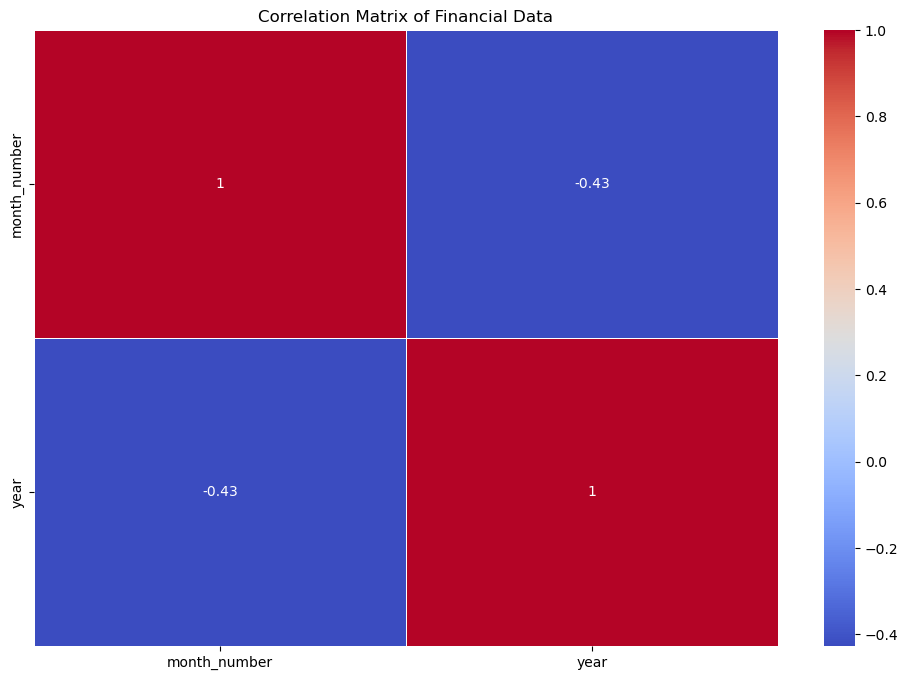

In [20]:
# Visualizing Key Statistics of the Data
print(df.info())
print(df.describe())

# 1. Correlation Matrix (existing, but adding more details)
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Financial Data')
plt.show()


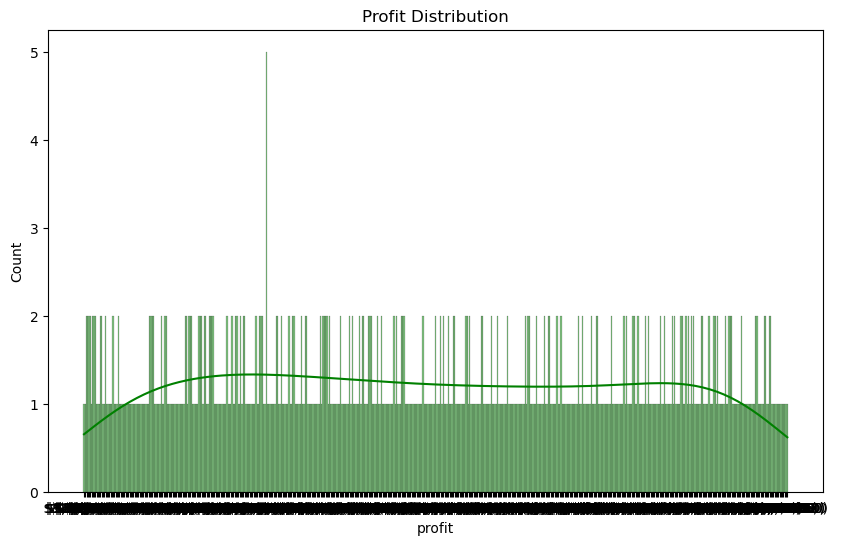

In [21]:
# 2. Profit Distribution Histogram (already added)
plt.figure(figsize=(10, 6))
sns.histplot(df['profit'], bins=20, kde=True, color='green')
plt.title('Profit Distribution')
plt.show()


In [24]:
print(df.dtypes)

segment                object
country                object
product                object
discount_band          object
units_sold             object
manufacturing_price    object
sale_price             object
gross_sales            object
discounts              object
sales                  object
cogs                   object
profit                 object
date                   object
month_number            int64
month_name             object
year                    int64
dtype: object


In [25]:
# Function to clean and convert columns to numeric
def clean_and_convert(column):
    # Replace non-numeric characters and convert to float
    return pd.to_numeric(column.replace('[\$,]', '', regex=True), errors='coerce')

# Clean and convert the relevant columns
columns_to_clean = [
    'units_sold', 
    'manufacturing_price', 
    'sale_price', 
    'gross_sales', 
    'discounts', 
    'sales', 
    'cogs', 
    'profit'
]

for col in columns_to_clean:
    df[col] = clean_and_convert(df[col])

# Handle missing values if necessary
df.fillna(0, inplace=True)

# Verify the data types after cleaning
print(df.dtypes)


segment                 object
country                 object
product                 object
discount_band           object
units_sold             float64
manufacturing_price    float64
sale_price             float64
gross_sales            float64
discounts              float64
sales                  float64
cogs                   float64
profit                 float64
date                    object
month_number             int64
month_name              object
year                     int64
dtype: object


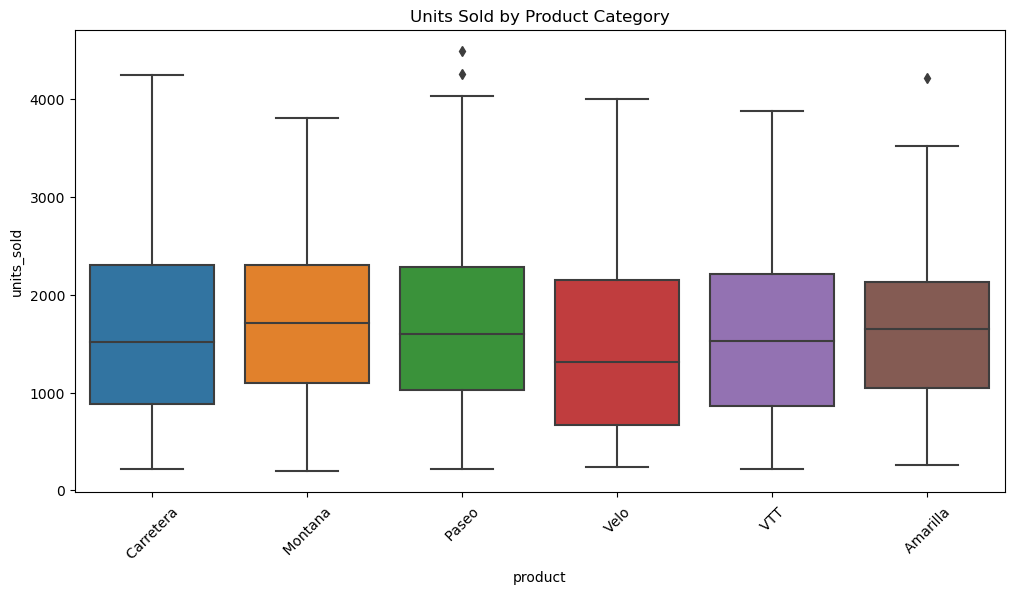

In [27]:
# 3. Units Sold by Product Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='product', y='units_sold')
plt.title('Units Sold by Product Category')
plt.xticks(rotation=45)
plt.show()


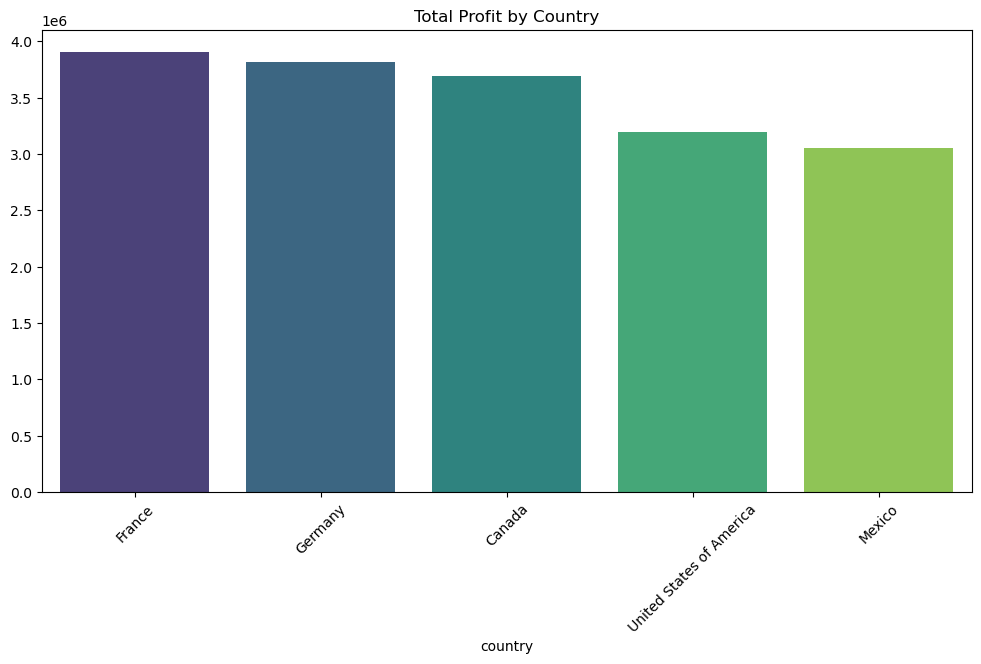

In [28]:
# 4. Profit by Country (Bar Plot)
plt.figure(figsize=(12, 6))
country_profit = df.groupby('country')['profit'].sum().sort_values(ascending=False)
sns.barplot(x=country_profit.index, y=country_profit.values, palette='viridis')
plt.title('Total Profit by Country')
plt.xticks(rotation=45)
plt.show()


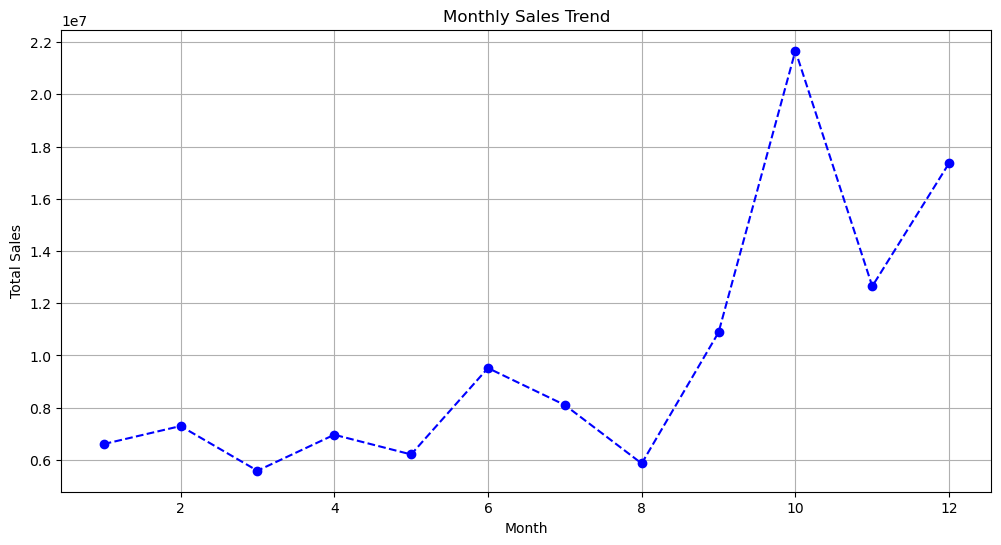

In [29]:
# 5. Monthly Sales Trend
plt.figure(figsize=(12, 6))
monthly_sales = df.groupby('month_number')['sales'].sum()
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='--', color='b')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

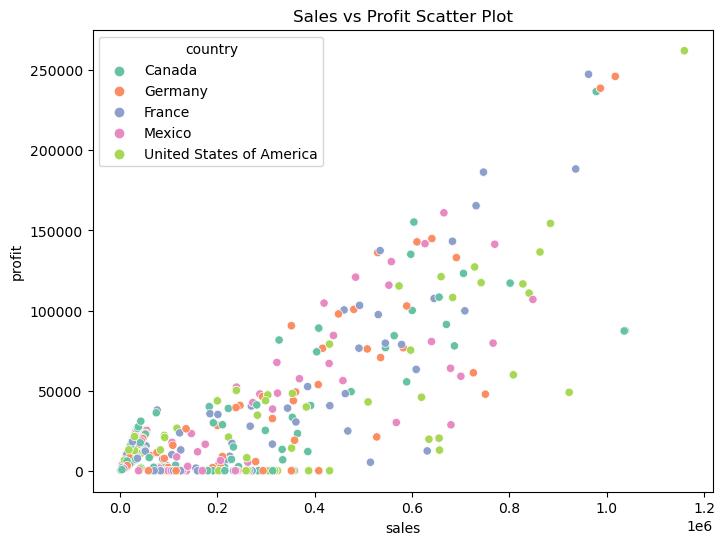

In [30]:
# 6. Sales vs Profit Scatter Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sales', y='profit', data=df, hue='country', palette='Set2')
plt.title('Sales vs Profit Scatter Plot')
plt.show()

In [31]:
# Feature Selection: Selecting relevant columns
features = ['units_sold', 'manufacturing_price', 'sale_price', 'gross_sales', 'discounts']
target = 'profit'

# Data Normalization (StandardScaler modified to MinMaxScaler)
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Splitting data into training and testing sets
X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Reshape the data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Building the LSTM Model (with slight modifications)
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(1))  # Output layer

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the LSTM model
lstm_loss = lstm_model.evaluate(X_test_lstm, y_test)
print(f'LSTM Model Loss: {lstm_loss}')




Epoch 1/50

14/14 [==============================] - 1s 26ms/step - loss: 2406789632.0000 - val_loss: 1413346688.0000
Epoch 2/50
14/14 [==============================] - 0s 5ms/step - loss: 2406777856.0000 - val_loss: 1413334400.0000
Epoch 3/50
14/14 [==============================] - 0s 5ms/step - loss: 2406746368.0000 - val_loss: 1413291136.0000
Epoch 4/50
14/14 [==============================] - 0s 5ms/step - loss: 2406599424.0000 - val_loss: 1413022336.0000
Epoch 5/50
14/14 [==============================] - 0s 5ms/step - loss: 2405270016.0000 - val_loss: 1410423936.0000
Epoch 6/50
14/14 [==============================] - 0s 5ms/step - loss: 2396149760.0000 - val_loss: 1394785152.0000
Epoch 7/50
14/14 [==============================] - 0s 5ms/step - loss: 2341927936.0000 - val_loss: 1324986368.0000
Epoch 8/50
14/14 [==============================] - 0s 5ms/step - loss: 2151543808.0000 - val_loss: 1131200768.0000
Epoch 9/50
14/14 [==============================] - 0s 5ms/step - lo

In [33]:
# Training an XGBoost Regressor (slightly different)
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Predict with the XGBoost model
xgb_predictions = xgb_model.predict(X_test)

# XGBoost evaluation
xgb_mse = mean_squared_error(y_test, xgb_predictions)
print(f'XGBoost Model Mean Squared Error: {xgb_mse}')


XGBoost Model Mean Squared Error: 111800232.3350518


5/5 [==============================] - 0s 2ms/step
Combined RMSE: 24519.014025652014


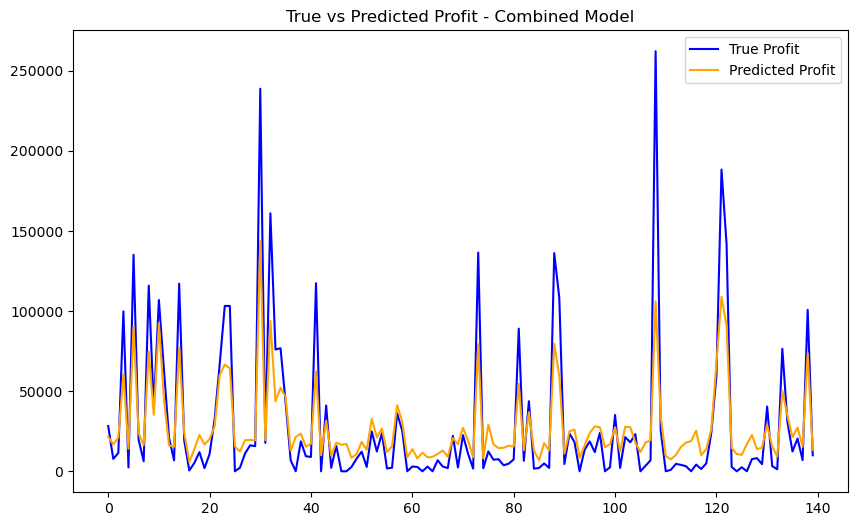

In [34]:
# Combine the predictions from both models
lstm_predictions = lstm_model.predict(X_test_lstm).flatten()
combined_predictions = (lstm_predictions + xgb_predictions) / 2

# Evaluate combined predictions
combined_mse = mean_squared_error(y_test, combined_predictions)
combined_rmse = np.sqrt(combined_mse)
print(f'Combined RMSE: {combined_rmse}')

# Compare the predictions visually
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Profit', color='blue')
plt.plot(combined_predictions, label='Predicted Profit', color='orange')
plt.legend()
plt.title('True vs Predicted Profit - Combined Model')
plt.show()

In [36]:
# Calculate Mean Absolute Percentage Error (MAPE) with handling for zero values
def calculate_mape(y_true, y_pred):
    # Create a mask for non-zero values
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Calculate MAPE
mape = calculate_mape(np.array(y_test), np.array(combined_predictions))

# Print evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')


Mean Absolute Error (MAE): 15061.642777762276
Mean Absolute Percentage Error (MAPE): 166.83396043692974%


In [37]:
# Saving the final combined predictions to a new CSV file
results_df = pd.DataFrame({'Actual Profit': y_test, 'Predicted Profit': combined_predictions})
results_df.to_csv('D:/JOB APPLIED/Combined_Model_Predictions.csv', index=False)